# calcPCs

This is the fourth step in reproducing the cluster analysis following [Amini and Straus 2019]
(https://doi.org/10.1007/s00382-018-4409-7)

This program calculates the EOFs and PCs.  PCs are written to an output file.
* Input: `/project/predictability/kpegion/wxregimes/era-interim/erai.z500_u250_pna_5dyrm_DJF.1980 2015.anoms.nc`
* Output: `/project/predictability/kpegion/wxregimes/era-interim/erai.z500_u250_pna_5dyrm_DJF.1980 2015.pcs.nc`

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker

from eofs.multivariate.standard import MultivariateEof
from eofs.xarray import Eof

### Define Input and Output Data

In [2]:
# Input
path='/project/predictability/kpegion/wxregimes/era-interim/'
fname='erai.z500_u250_pna_5dyrm_DJF.1980-2015.anoms.nc'

# Output
outfile='erai.z500_u250_pna_5dyrm_DJF.1980-2015.pcs.nc'

### Define constants

In [3]:
npcs=12

### Read Data

In [4]:
print(path+fname)
ds=xr.open_dataset(path+fname,decode_times=False)

/project/predictability/kpegion/wxregimes/era-interim/erai.z500_u250_pna_5dyrm_DJF.1980-2015.anoms.nc


<xarray.Dataset>
Dimensions:  (lat: 22, lon: 53, time: 3080)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 ... 3073 3074 3075 3076 3077 3078 3079
  * lat      (lat) float64 79.53 76.74 73.95 71.16 ... 29.3 26.51 23.72 20.93
  * lon      (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
Data variables:
    z500     (time, lat, lon) float64 -145.7 -153.4 -159.7 ... 45.93 46.04 45.02
    u250     (time, lat, lon) float64 ...

### Convert Z500 from X to Y

In [ ]:
ds['z500']=ds['z500']/9.81
ds

### Quick test plot

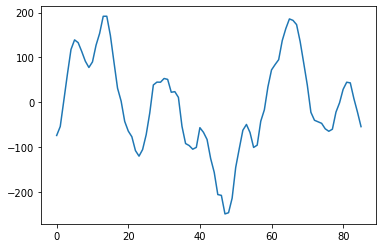

In [6]:
plt.plot(ds['z500'][0:88,12,25])

### Calculate Latitude Weights

In [7]:
coslat = np.cos(np.deg2rad(ds['lat'].values))
weights_array = np.sqrt(coslat)[:, np.newaxis]

### Apply Latitude Weighting

In [8]:
ds['z500']=ds['z500']*weights_array
ds['u250']=ds['u250']*weights_array

### Normalize the Data

In [9]:
norm_z500=np.sqrt((ds['z500'].var(dim='time')).mean(dim=['lat','lon']))
norm_u250=np.sqrt(ds['u250'].var(dim='time').mean(dim=['lat','lon']))

ds['z500']=ds['z500']/norm_z500
ds['u250']=ds['u250']/norm_u250

### Check values of normalization (this the variance, normalized by std)

In [10]:
print(norm_z500.values*norm_z500.values)
print(norm_u250.values*norm_u250.values)

5920.157848168376
89.21151510943824


### Create the eof solver with latitude weighted data

In [11]:
solver=MultivariateEof([ds['z500'].values,ds['u250'].values])

### Get the EOF (spatial pattern)

In [12]:
eof1_list=solver.eofs(neofs=npcs,eofscaling=0)

(12, 22, 53)
[[ 0.0009496   0.00099597  0.0010506  ... -0.00138053 -0.00126566
  -0.00114925]
 [ 0.00058971  0.00072702  0.00088688 ... -0.00225086 -0.00207893
  -0.00194456]
 [ 0.00038195  0.00068575  0.00102775 ... -0.00369262 -0.00349355
  -0.00334066]
 ...
 [-0.00125085 -0.00180025 -0.00231843 ...  0.00930994  0.00768248
   0.00600087]
 [-0.00286946 -0.0035057  -0.00415042 ...  0.00453185  0.00319069
   0.00177507]
 [-0.00344392 -0.00408186 -0.00474826 ...  0.00072938 -0.00036799
  -0.0014912 ]]


### Plot the EOFs

In [13]:
# Map settings
cm = 180
proj = ccrs.PlateCarree(central_longitude=cm)
minlon = -30 + cm
maxlon = +120 + cm
lat_labels=np.arange(20,80,20)
lon_labels=np.arange(150,330,30)
extent=[minlon,maxlon,20,80]

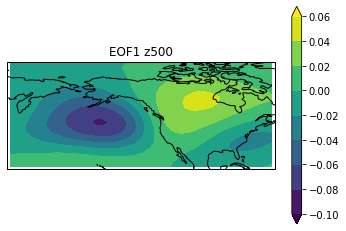

In [15]:
# EOF 1 Z500
levs=np.arange(-0.1,0.07,0.02)
z500_eof1=eof1_list[0][0,:,:]/weights_array
ax=plt.axes(projection=proj)
ax.set_extent(extent,crs=ccrs.PlateCarree())
cs=ax.contourf(ds['lon'],ds['lat'],
               z500_eof1*-1,levs,
               transform=ccrs.PlateCarree(),
              extend='both')
ax.set_title('EOF1 z500')
ax.coastlines()
plt.colorbar(cs)

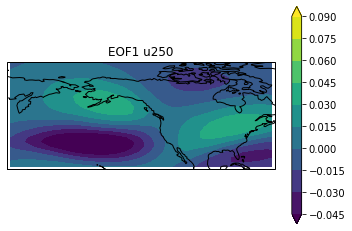

In [16]:
# EOF 1 U250
levs=np.arange(-0.045,0.1,0.015)
u250_eof1=eof1_list[1][0,:,:]/weights_array
ax=plt.axes(projection=proj)
ax.set_extent(extent,crs=ccrs.PlateCarree())
cs=ax.contourf(ds['lon'],ds['lat'],
               u250_eof1,levs,
               transform=ccrs.PlateCarree(),
               extend='both')
ax.set_title('EOF1 u250')
ax.coastlines()
plt.colorbar(cs)

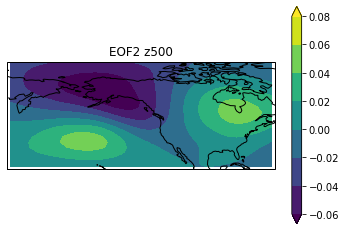

In [17]:
# EOF 2 Z500
levs=np.arange(-0.06,0.08,0.02)
z500_eof2=eof1_list[0][1,:,:]/weights_array
ax=plt.axes(projection=proj)
ax.set_extent(extent,crs=ccrs.PlateCarree())
cs=ax.contourf(ds['lon'],ds['lat'],
               z500_eof2,levs,
               transform=ccrs.PlateCarree(),
               extend='both')
ax.set_title('EOF2 z500')
ax.coastlines()
plt.colorbar(cs)

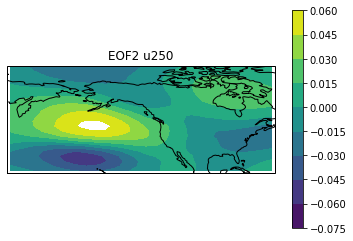

In [18]:
# EOF 2 U250
levs=np.arange(-0.075,0.07,0.015)
u250_eof2=eof1_list[1][1,:,:]/weights_array
ax=plt.axes(projection=proj)
ax.set_extent(extent,crs=ccrs.PlateCarree())
cs=ax.contourf(ds['lon'],ds['lat'],
               u250_eof2,levs,
               transform=ccrs.PlateCarree(),extend='both')
ax.set_title('EOF2 u250')
ax.coastlines()
plt.colorbar(cs)

### Get the First 12 PCs

In [19]:
pcs = solver.pcs(npcs=npcs, pcscaling=0)
pcs.shape

(3080, 12)

### Find out how much variance is explained by first 12 PCs; Amini and Straus found about 80%

In [20]:
variance_fractions = solver.varianceFraction(neigs=npcs)
variance_fractions.sum()*100

### Put PCs into `xr.Dataset`

In [22]:
pcs_ds=xr.DataArray(pcs,
                    coords={'time': ds['time'].values,
                            'pcnum':np.arange(npcs)},
                            dims=['time','pcnum'])        
pcs_ds=pcs_ds.to_dataset(name='pcs')

In [23]:
pcs_ds

<xarray.Dataset>
Dimensions:  (pcnum: 12, time: 3080)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 ... 3073 3074 3075 3076 3077 3078 3079
  * pcnum    (pcnum) int64 0 1 2 3 4 5 6 7 8 9 10 11
Data variables:
    pcs      (time, pcnum) float64 1.803 -23.58 27.72 ... 3.291 4.864 -6.262

### Plot the first PC

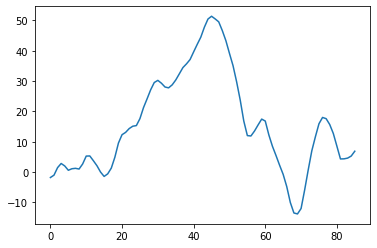

In [24]:
plt.plot(pcs_ds['pcs'][0:88,0]*-1)

In [26]:
pcs_ds.to_netcdf(path+outfile)